# Data loading

In [1]:
import pandas as pd

In [2]:
train_var = pd.read_csv('training/training_variants')
test_var = pd.read_csv('testing/test_variants.csv')

In [3]:
train_var.shape

(3321, 4)

In [4]:
test_var.shape

(986, 3)

In [5]:
train_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [6]:
train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [7]:
train_var['Class'].value_counts().sort_values(ascending=False)

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

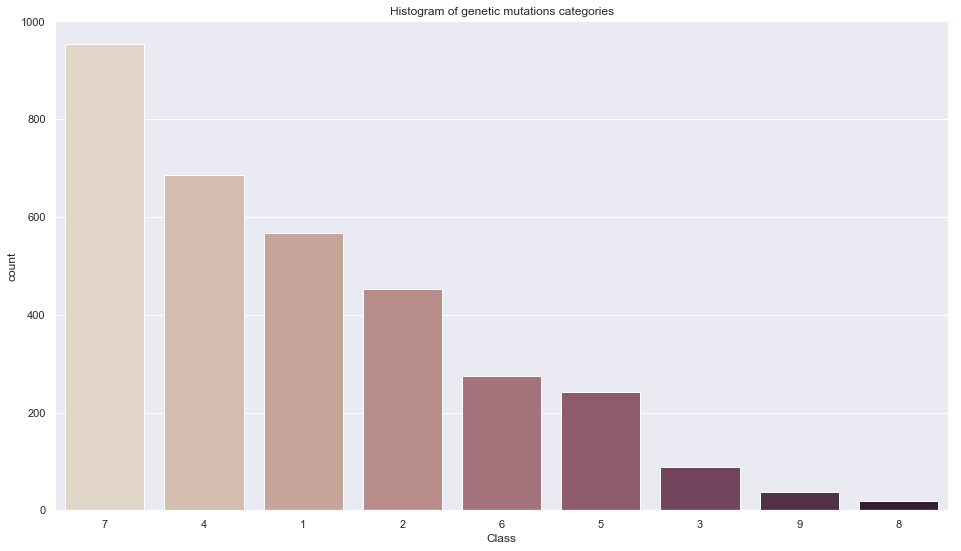

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style='darkgrid')
plt.figure(figsize=(16,9))
sns.countplot(train_var['Class'],order = train_var['Class'].value_counts().index, palette="ch:.25")
plt.title('Histogram of genetic mutations categories')
plt.show()

We see that data is not "equally" distributed between classes, we will pay attention to this when splitting data 

In [9]:
gene_count = train_var['Gene'].value_counts().sort_values(ascending=False).to_frame()

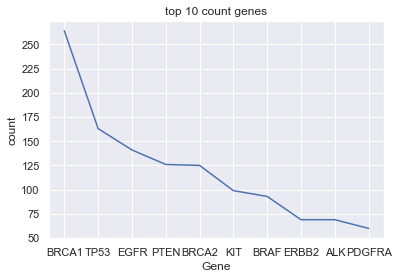

In [10]:
plt.plot(gene_count[:10])
plt.title('top 10 count genes')
plt.xlabel('Gene')
plt.ylabel('count')
plt.show()

In [11]:
train_text = pd.read_csv("training/training_text",
                       encoding='latin1',
                       sep="\|\|",
                       header=None,
                       skiprows=1,
                       names=['ID','text'])
test_text = pd.read_csv("testing/test_text.csv",
                      encoding='latin1',
                      sep="\|\|",
                      header=None,
                      skiprows=1,
                      names=['ID','text'])

C:\Users\fatma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\fatma\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':


In [12]:
train_text.shape

(3321, 2)

In [13]:
train_text.head()

,ID,text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [14]:
train_text['text'].map(len).describe()

count      3321.000000
mean      63865.608853
std       52373.218506
min           4.000000
25%       31450.000000
50%       46292.000000
75%       80347.000000
max      525740.000000
Name: text, dtype: float64

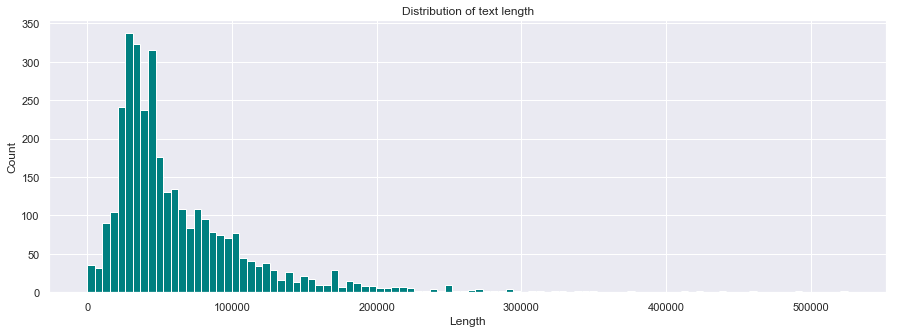

In [15]:
train_text['text'].map(len).hist(figsize=(15, 5), bins=100, color='teal')
plt.title('Distribution of text length')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

We observe that the majority of documents have their length lower than 100000

Now, we merge the two data frames (text and variants) by ID then we focus on building features for textual data

In [16]:
train = pd.merge(train_var, train_text, how='left', on='ID')

In [17]:
test = pd.merge(test_var, test_text, how='left', on='ID')

In [18]:
train['Text_count'] = train['text'].map(len).to_frame()

<Figure size 1152x648 with 0 Axes>

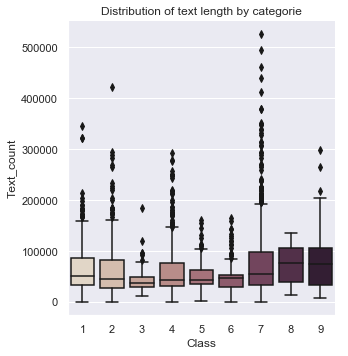

In [19]:
plt.figure(figsize=(16,9))
sns.catplot(x='Class', y='Text_count', data=train, kind='box',  palette="ch:.25")
plt.title("Distribution of text length by categorie")
plt.show()

Text length differs from one class to another. We find longer texts in classes: 7, 8 and 9

In [20]:
train = train.drop('Text_count', axis=1)

# Feature Engineering

In [21]:
import re
import numpy as np 
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from tqdm import tqdm

In [22]:
stop_words = set(stopwords.words('english')) 

The first step before building features is to tokenize the textual data, to do so, we define the function 'tokenize'

In [24]:
def tokenize(text):
    """
    keeps only alphanumeric characters, 
    removes whitespaces, 
    'lowers' the text
    then applies the function word_tokenize from nltk
    """
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip().lower()
    tokens = [w for w in word_tokenize(text) if not w in stop_words]
    return tokens

In [25]:
tqdm.pandas(desc="progress-bar")
train['tokens'] = train['text'].progress_map(tokenize)
train['cleaned_text'] = train['tokens'].map(lambda tokens: ' '.join(tokens))
train[['ID','cleaned_text','Gene','Variation','Class']].to_csv('training/cleaned_train.csv')

progress-bar: 100%|████████████████████████████████████████████████████████████████| 3321/3321 [03:50<00:00, 18.77it/s]


In [26]:
train['tokens'].map(len).describe()

count     3321.000000
mean      6316.054803
std       5217.203877
min          1.000000
25%       3150.000000
50%       4619.000000
75%       7886.000000
max      51715.000000
Name: tokens, dtype: float64

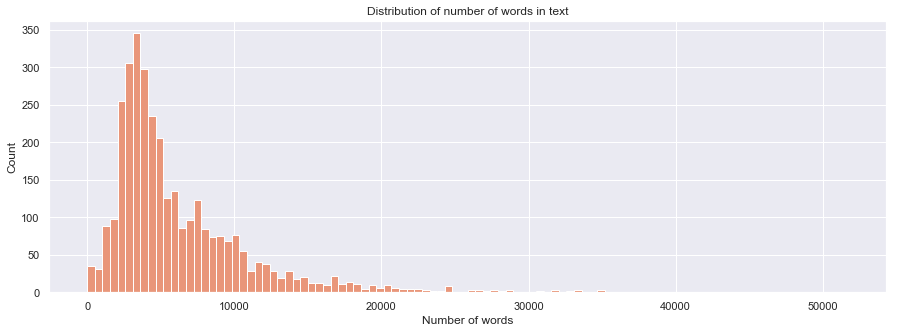

In [27]:
train['tokens'].map(len).hist(figsize=(15, 5), bins=100, color='darksalmon')
plt.title('Distribution of number of words in text')
plt.xlabel('Number of words')
plt.ylabel('Count')
plt.show()

After tokenization, we plot the word counts. We can see that most documents have a number of words under 10000. 

In [28]:
cleaned_train = pd.read_csv('training/cleaned_train.csv',
                           encoding='latin1',
                           usecols=['ID','cleaned_text','Gene','Variation','Class'])

In [29]:
cleaned_train.head()

,ID,cleaned_text,Gene,Variation,Class
0,0,cyclindependent kinases cdks regulate variety ...,FAM58A,Truncating Mutations,1
1,1,abstract background nonsmall cell lung cancer ...,CBL,W802*,2
2,2,abstract background nonsmall cell lung cancer ...,CBL,Q249E,2
3,3,recent evidence demonstrated acquired uniparen...,CBL,N454D,3
4,4,oncogenic mutations monomeric casitas blineage...,CBL,L399V,4


In [30]:
from nltk.probability import FreqDist
doc = ' '.join(cleaned_train['cleaned_text'].tolist())
fdist = FreqDist(word_tokenize(doc))

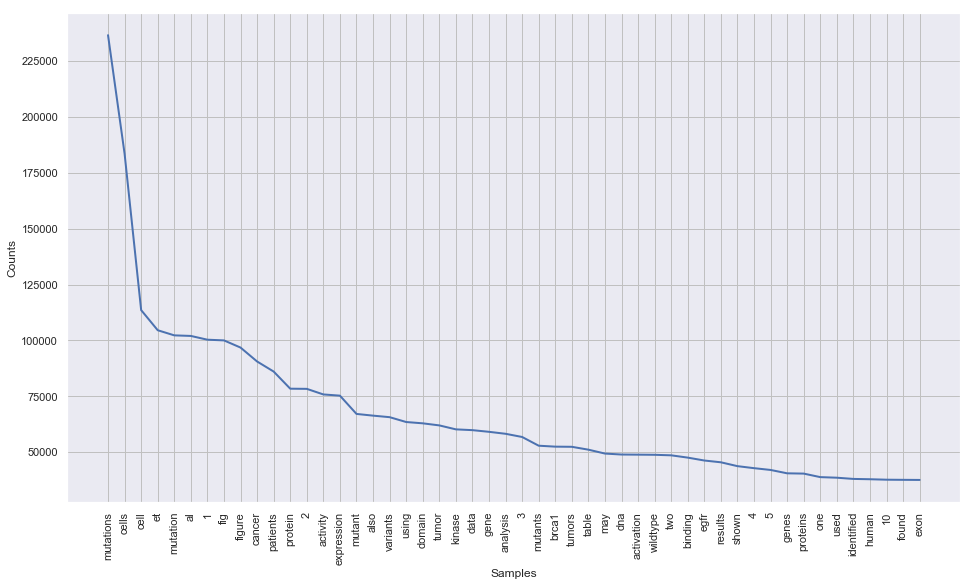

In [31]:
plt.figure(figsize=(16,9))
fdist.plot(50, cumulative=False)
plt.show()

Most frequent words are: mutations, cell, mutant, protein... 

In [32]:
from wordcloud import WordCloud

def plot_word_cloud(terms):
    t = ' '.join(list(terms))
    wordcloud = WordCloud(max_font_size=40, background_color="white").generate(t)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

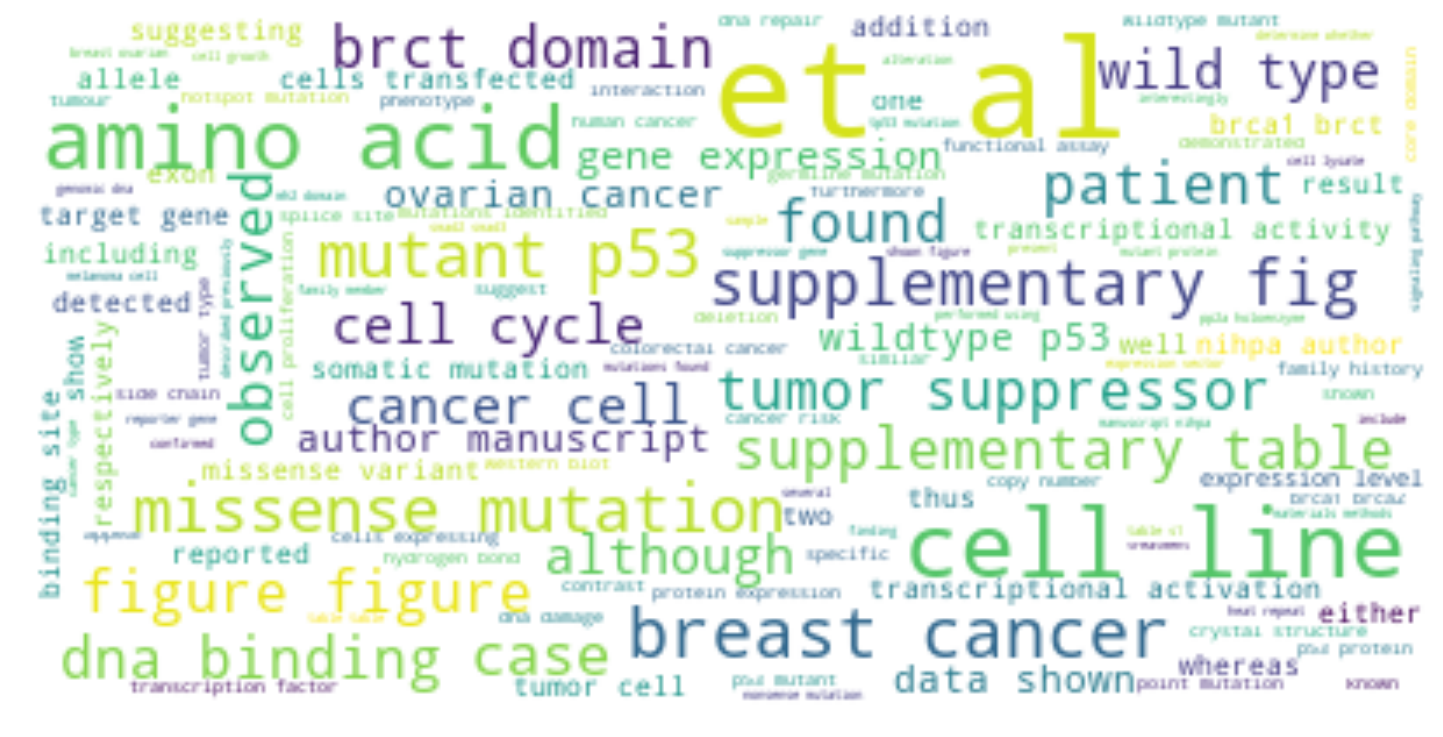

In [33]:
plot_word_cloud(cleaned_train[cleaned_train['Class'] == 1].cleaned_text)

The wordcloud represents most frequent words in documents belonging to class 1

Let's split our data set into a training set and a testing set 
and in order to avoid bias (we saw in the histogram that the classes are not uniformly distributed), we use StratifiedShuffleSplit

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index,val_index in split.split(cleaned_train,cleaned_train['Class']):
    train_subset = cleaned_train.loc[train_index]
    val_subset = cleaned_train.loc[val_index]

In [35]:
train_subset.shape

(2656, 5)

In [36]:
val_subset.shape

(665, 5)

In [37]:
X_train,X_val,y_train,y_val = train_subset.drop('Class',axis=1),val_subset.drop('Class',axis=1),train_subset['Class'],val_subset['Class']

## First Technique: Tfidf on words

The first tool we are going to use to do feature engineering is tf–idf (term frequency–inverse document frequency). It shows how important a word is to a document in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general(Source Wikipedia).

This method is already implemented in sklearn via TfidfVectorizer.

In [38]:
from tqdm import tqdm_notebook
vectorizer_word = TfidfVectorizer(analyzer='word', min_df=5, max_df=0.5)
vectorizer_word.fit(tqdm_notebook(X_train['cleaned_text']))

A Jupyter Widget

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [39]:
tfidf_matrix_word_train = vectorizer_word.transform(X_train['cleaned_text'])
tfidf_matrix_word_val = vectorizer_word.transform(X_val['cleaned_text'])

C:\Users\fatma\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1039: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [40]:
tfidf_matrix_word_train[0,0]

0.00588283640167936

In [41]:
tfidf_matrix_word_train.shape

(2656, 60075)

In [42]:
tfidf_matrix_word_val.shape

(665, 60075)

The dimension is important! We have to apply dimensionality reduction techniques like SVD

In [43]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 250)
svd.fit(tfidf_matrix_word_train) 
svd.explained_variance_ratio_.sum()

0.7550210308929739

In [44]:
tfidf_svd_word_train = svd.transform(tfidf_matrix_word_train)
tfidf_svd_word_val = svd.transform(tfidf_matrix_word_val)

In [45]:
tfidf_svd_word_train.shape

(2656, 250)

In [46]:
tfidf_svd_word_val.shape

(665, 250)

### Cross Validation with tf-idf on words

We would like now to train different models with cross validation to select the one that gives the least log loss

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import log_loss

In [48]:
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('K-Nearest Neighbors', KNeighborsClassifier()))
models.append(('Decision Trees', DecisionTreeClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('SVM', SVC(probability=True)))
names = []
for name,model in models:
    names.append(name)

In [49]:
def cv_results(X,y,models):
    results = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=42)
        cv_results = model_selection.cross_val_predict(model, X, y, cv=kfold,method='predict_proba')
        results.append(log_loss(y,cv_results))
        msg = "%s: %f" % (name, log_loss(y,cv_results))
        print(msg)
    return(results)

In [50]:
results = cv_results(tfidf_svd_word_train, y_train, models)

Logistic Regression: 1.162084
K-Nearest Neighbors: 4.544685
Decision Trees: 11.839795
Gaussian Naive Bayes: 14.227639
SVM: 1.179810


Top models are then : SVM and Logistic regression. Next step will be to hypertune their parameters. We will only focus on logistic regression since SVM is very time consuming  

### Grid Search on Logistic Regression

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
model_lr = LogisticRegression()
clf_lr = GridSearchCV(model_lr, 
                      param_grid={'tol':(1e-3,1e-4),
                                  'solver':('newton-cg','lbfgs'),
                                  'multi_class':('ovr','multinomial'),
                                  'C':[1, 10, 15]}, 
                      cv=5,
                      scoring='neg_log_loss')
clf_lr.fit(tfidf_svd_word_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'tol': (0.001, 0.0001), 'solver': ('newton-cg', 'lbfgs'), 'multi_class': ('ovr', 'multinomial'), 'C': [1, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [53]:
-(clf_lr.best_score_),clf_lr.best_params_

(1.0578817851131186,
 {'C': 10, 'multi_class': 'ovr', 'solver': 'lbfgs', 'tol': 0.001})

In [54]:
model_lr = clf_lr.best_estimator_

### Testing Logistic Regression on the validation set after Grid Search

In [55]:
print("validation set-Logistic Regression-log loss:",log_loss(y_val,model_lr.predict_proba(tfidf_svd_word_val)))

validation set-Logistic Regression-log loss: 1.1188580248468045


In [56]:
y_lr_val = model_lr.predict(tfidf_svd_word_val)

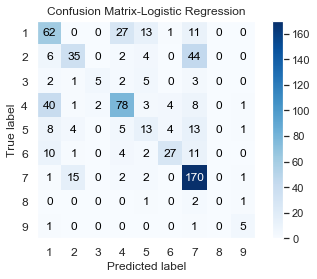

In [57]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_val, y_lr_val)
plt.title('Confusion Matrix-Logistic Regression')
plt.show()

## 2nd Technique: Tfidf on word bigrams

Now let's try out another feature engineering techniques. we'll build our features based on unigrams and bigrams

In [58]:
from tqdm import tqdm_notebook
vectorizer_bigram = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=5, max_df=0.5)
vectorizer_bigram.fit(tqdm_notebook(X_train['cleaned_text']))

A Jupyter Widget

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [59]:
tfidf_matrix_bigram_train = vectorizer_bigram.transform(X_train['cleaned_text'])
tfidf_matrix_bigram_val = vectorizer_bigram.transform(X_val['cleaned_text'])

C:\Users\fatma\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1039: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [60]:
tfidf_matrix_bigram_train.shape

(2656, 585773)

In [61]:
tfidf_matrix_bigram_val.shape

(665, 585773)

In [62]:
svd_bigram = TruncatedSVD(n_components = 250)
svd_bigram.fit(tfidf_matrix_bigram_train) 
svd_bigram.explained_variance_ratio_.sum()

0.7110012162108601

In [63]:
tfidf_svd_bigram_train = svd_bigram.transform(tfidf_matrix_bigram_train)
tfidf_svd_bigram_val = svd_bigram.transform(tfidf_matrix_bigram_val)

In [64]:
model_lr_bigram = LogisticRegression()
clf_lr_bigram = GridSearchCV(model_lr_bigram, 
                      param_grid={'tol':(1e-3,1e-4),
                                  'solver':('newton-cg','lbfgs'),
                                  'multi_class':('ovr','multinomial'),
                                  'C':[1, 10, 15]}, 
                      cv=5,
                      scoring='neg_log_loss')
clf_lr_bigram.fit(tfidf_svd_bigram_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'tol': (0.001, 0.0001), 'solver': ('newton-cg', 'lbfgs'), 'multi_class': ('ovr', 'multinomial'), 'C': [1, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [65]:
-(clf_lr_bigram.best_score_),clf_lr_bigram.best_params_

(1.0418628516423971,
 {'C': 10, 'multi_class': 'ovr', 'solver': 'newton-cg', 'tol': 0.0001})

In [66]:
model_lr_bigram = clf_lr_bigram.best_estimator_

In [67]:
print("validation set-Logistic Regression- word bigram-log loss:",log_loss(y_val,model_lr_bigram.predict_proba(tfidf_svd_bigram_val)))

validation set-Logistic Regression- word bigram-log loss: 1.1169418206186668


Results are better than before with unigrams

In [68]:
y_lr_bigram_val = model_lr_bigram.predict(tfidf_svd_bigram_val)

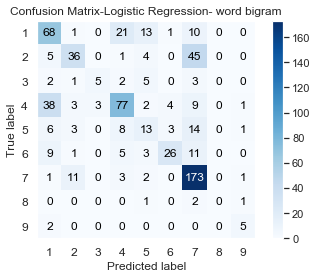

In [69]:
skplt.plot_confusion_matrix(y_val, y_lr_bigram_val)
plt.title('Confusion Matrix-Logistic Regression- word bigram')
plt.show()

not that great! we will use the first model (tf idf with words) for our submissions

# Making our submissions (bigrams)

We won't make a pipeline now for the whole process. We will wait until we have better scores

In [70]:
tqdm.pandas(desc="progress-bar")
test['tokens'] = test['text'].progress_map(tokenize)
test['cleaned_text'] = test['tokens'].map(lambda tokens: ' '.join(tokens))
test[['ID','cleaned_text','Gene','Variation']].to_csv('testing/cleaned_test.csv')
cleaned_test = pd.read_csv('testing/cleaned_test.csv',
                           encoding='latin1',
                           usecols=['ID','cleaned_text','Gene','Variation'])

progress-bar: 100%|██████████████████████████████████████████████████████████████████| 986/986 [01:04<00:00, 15.32it/s]


In [71]:
tfidf_matrix_bigram_test = vectorizer_bigram.transform(cleaned_test['cleaned_text'])
tfidf_svd_bigram_test = svd_bigram.transform(tfidf_matrix_bigram_test)

C:\Users\fatma\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1039: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [72]:
tfidf_svd_bigram = np.vstack([tfidf_svd_bigram_train,tfidf_svd_bigram_val])
final_model = LogisticRegression(C= 10, multi_class= 'ovr', solver= 'newton-cg', tol= 0.001)
final_model.fit(tfidf_svd_bigram, pd.concat([y_train,y_val]))
y_lr = final_model.predict_proba(tfidf_svd_bigram_test)

In [73]:
def file_submission(y,id_column,file_path):
    df = pd.DataFrame(y, columns=['class1','class2','class3','class4','class5','class6','class7','class8','class9'])
    df.insert(loc=0, column='Id', value=id_column)
    df.to_csv(file_path, index=False)

In [74]:
file_submission(y_lr, cleaned_test['ID'], 'testing/results_lr_bigram_250_full.csv')

These are the results of our submissions:
![score](lr_sgram_sub2.PNG)

The public score is quite good: 1.148 while the private score is higher: 3.029. Our model is overfitting, we have to figure out a way to avoid that

# Trying out svm

In [75]:
model_svm = SVC(kernel='rbf', probability=True) #rbf kernel usually performs well
clf_svm = GridSearchCV(model_svm, 
                       param_grid={'C':[1,10,15]}, 
                       cv=3,
                       scoring='neg_log_loss')
clf_svm.fit(tfidf_svd_bigram_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'C': [1, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [76]:
-(clf_svm.best_score_)

1.1526103707433624

In [77]:
clf_svm.best_params_

{'C': 15}

In [78]:
model_svm = clf_svm.best_estimator_

In [79]:
print("validation set-SVM-log loss:",log_loss(y_val,model_svm.predict_proba(tfidf_svd_bigram_val)))

validation set-SVM-log loss: 1.1876456183838748


The performance of SVM model is lower than the one of logistic regression

In [80]:
y_svm_val = model_svm.predict(tfidf_svd_bigram_val)

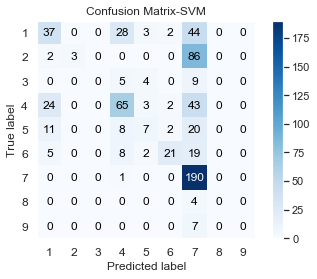

In [81]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_val, y_svm_val)
plt.title('Confusion Matrix-SVM')
plt.show()

almost all predicted labels are 7

# Ensemble methods

## Voting

Let's try a voting classifier with our logistic regression model, svm model and a KNN classifier

In [82]:
from sklearn.ensemble import VotingClassifier
model_voting = VotingClassifier(
        estimators=[('lr',model_lr),('svm',model_svm),('KNN',KNeighborsClassifier())],
        voting='soft')
model_voting.fit(tfidf_svd_bigram_train,y_train)
print("validation set-voting-log loss:",log_loss(y_val,model_voting.predict_proba(tfidf_svd_bigram_val)))

validation set-voting-log loss: 1.0832891546331849


In [83]:
y_voting = model_voting.predict_proba(tfidf_svd_bigram_test)
file_submission(y_voting, cleaned_test['ID'], 'testing/results_voting_bis.csv')

![score_voting](sub_vot_bis2.png)

We got a slightly better result when submitting (Public Score: 1.144, Private Score: 3.001)

## Hyperparameter tuning SVD

In [84]:
from sklearn.pipeline import Pipeline

In [85]:
tfidf_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(analyzer = 'word',ngram_range = (1,2), min_df = 5, max_df = 0.5)),
    ('svd',TruncatedSVD()),
    ('lr',LogisticRegression(C = 10, multi_class = 'ovr', solver = 'newton-cg', tol = 0.001))
])

In [86]:
clf_svd = GridSearchCV(tfidf_pipeline, 
                      param_grid={'svd__n_components' : [25,100,250]}, 
                      cv=5,
                      scoring='neg_log_loss')
clf_svd.fit(cleaned_train['cleaned_text'],cleaned_train['Class'])

C:\Users\fatma\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1039: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\fatma\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1039: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\fatma\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1039: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\fatma\Anacond

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_...lty='l2', random_state=None, solver='newton-cg', tol=0.001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svd__n_components': [25, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [87]:
-(clf_svd.best_score_),clf_svd.best_params_

(1.6872362064040107, {'svd__n_components': 25})

In [88]:
final_model = clf_svd.best_estimator_

In [89]:
y_pred_cv_svd = final_model.predict_proba(cleaned_test['cleaned_text'])

C:\Users\fatma\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1039: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [90]:
file_submission(y_pred_cv_svd, cleaned_test['ID'], 'testing/results_final_model0.csv')

![score_voting](final_model0.png)

Private score: 2.78684, Public score: 1.42376

# Deep Learning - LSTM (Long Short Term Memory)

The first layer of this deep learning model is the embedding layer. In an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. The position of a word in the learned vector space is referred to as its embedding.

Keras offers an Embedding layer that can be used for neural networks on text data.It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API.

In [91]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

C:\Users\fatma\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Preparation step - Tokenizing

We will be using the preprocessed text (with stopwords removal) since Keras doesn't provide methods for NLP

In [92]:
max_num_words = 6000 #mean number of words seen in data visualization
tokenizer = Tokenizer(num_words = max_num_words)
tokenizer.fit_on_texts(cleaned_train['cleaned_text'])

In [93]:
X_lstm = tokenizer.texts_to_sequences(cleaned_train['cleaned_text'])
X_lstm = pad_sequences(X_lstm, maxlen = max_num_words)

### Building the DL model

In [94]:
embed_dim = 128 #output dimension for Embedding layer
lstm_out = 196 #output dimension for LSTM layer

In [95]:
ckpt_callback = ModelCheckpoint('keras_model_v1', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

lstm_model = Sequential()
lstm_model.add(Embedding(max_num_words, embed_dim, input_length = max_num_words)) 
#Turns positive integers (indexes) into dense vectors of fixed size
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be
# no larger than max_num_words (vocabulary size).
# the output is a 3D tensor with shape == (None, max_num_words, embed_dim), where None is the batch dimension.
lstm_model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
#recurrent dropout: Fraction of the units to drop for the linear transformation of the recurrent state.
#dropout: Fraction of the units to drop for the linear transformation of the inputs.
lstm_model.add(Dense(9,activation='softmax'))
#output dim => number of classes:9
lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(lstm_model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6000, 128)         768000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 1,024,573
Trainable params: 1,024,573
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
y = pd.get_dummies(cleaned_train['Class']).values #performs "one hot encoding" on labels 
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_lstm, y, test_size = 0.2, random_state = 42, stratify=y)

In [ ]:
batch_size = 32
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

Train on 2124 samples, validate on 532 samples
Epoch 1/8
2124/2124 [==============================] - 6611s - loss: 1.8671 - categorical_crossentropy: 1.8671 - val_loss: 1.7287 - val_categorical_crossentropy: 1.7287
Epoch 2/8
2124/2124 [==============================] - 6366s - loss: 1.3686 - categorical_crossentropy: 1.3686 - val_loss: 1.1743 - val_categorical_crossentropy: 1.1743
Epoch 3/8


2124/2124 [==============================] - 6704s - loss: 0.8714 - categorical_crossentropy: 0.8714 - val_loss: 1.0198 - val_categorical_crossentropy: 1.0198
Epoch 4/8
2124/2124 [==============================] - 7286s - loss: 0.6371 - categorical_crossentropy: 0.6371 - val_loss: 1.0349 - val_categorical_crossentropy: 1.0349
Epoch 5/8


2124/2124 [==============================] - 56396s - loss: 0.5475 - categorical_crossentropy: 0.5475 - val_loss: 1.0089 - val_categorical_crossentropy: 1.0089
Epoch 6/8
2124/2124 [==============================] - 7985s - loss: 0.4906 - categorical_crossentropy: 0.4906 - val_loss: 1.0462 - val_categorical_crossentropy: 1.0462
Epoch 7/8
 928/2124 [============>.................] - ETA: 6593s - loss: 0.3209 - categorical_crossentropy: 0.320 - ETA: 6590s - loss: 0.3119 - categorical_crossentropy: 0.311 - ETA: 6527s - loss: 0.3808 - categorical_crossentropy: 0.380 - ETA: 6528s - loss: 0.3749 - categorical_crossentropy: 0.374 - ETA: 6434s - loss: 0.3833 - categorical_crossentropy: 0.383 - ETA: 6336s - loss: 0.3962 - categorical_crossentropy: 0.396 - ETA: 6242s - loss: 0.4061 - categorical_crossentropy: 0.406 - ETA: 6150s - loss: 0.4014 - categorical_crossentropy: 0.401 - ETA: 6041s - loss: 0.4109 - categorical_crossentropy: 0.410 - ETA: 5944s - loss: 0.4144 - categorical_crossentropy: 0.41

In [ ]:
lstm_model = load_model('keras_model_v1')

In [ ]:
probas = lstm_model.predict(X_val_lstm)

In [ ]:
print("validation set-LSTM-log loss:",log_loss(y_val_lstm,probas))

In [ ]:
y_pred_val = np.apply_along_axis(lambda x:np.argmax(x) + 1, 1, probas)

In [ ]:
skplt.plot_confusion_matrix(np.apply_along_axis(lambda x:np.argmax(x) + 1, 1, y_val_lstm), y_pred_val)
plt.title('Confusion Matrix-LSTM')
plt.show()

The confusion matrix seems to be pretty good but we still have bias in class 7

### Making predictions on test set with LSTM model

In [ ]:
X_test_lstm = tokenizer.texts_to_sequences(cleaned_test['cleaned_text'])
X_test_lstm = pad_sequences(X_test_lstm, maxlen=6000)

In [ ]:
res_probas = lstm_model.predict(X_test_lstm)

In [ ]:
file_submission(res_probas, cleaned_test['ID'], 'testing/results_LSTM.csv')

The result is not very satisfying Public Score: 1.54299, Private Score:3.30259